# Basic depiction of a FEP workflow using BioSimSpace and Python

In [10]:
import BioSimSpace as BSS
import glob 
import csv
import numpy as np

### Variables

In [25]:
path_to_ligands = "inputs/ligands"
path_to_protein = "inputs/protein/tyk2"

## 1. With our collection of ligands, figure out which perturbations we should run.

The reliability of FEP calculations is typically higher for transformations with fewer heavy atom changes and some other rules (e.g. no ring formations). LOMAP is a package that contains heuristics for this and is able to come up with a network for us; BioSimSpace contains a function generateNetwork() that uses LOMAP to come up with the perturbation network that visualises the desired perturbations. Additionally, a LOMAP score is calculated which quantifies the likeliness that the FEP prediction will be reliable (0 means unlikely, 1 means highly likely).

This function requires a list of BioSimSpace molecule objects.

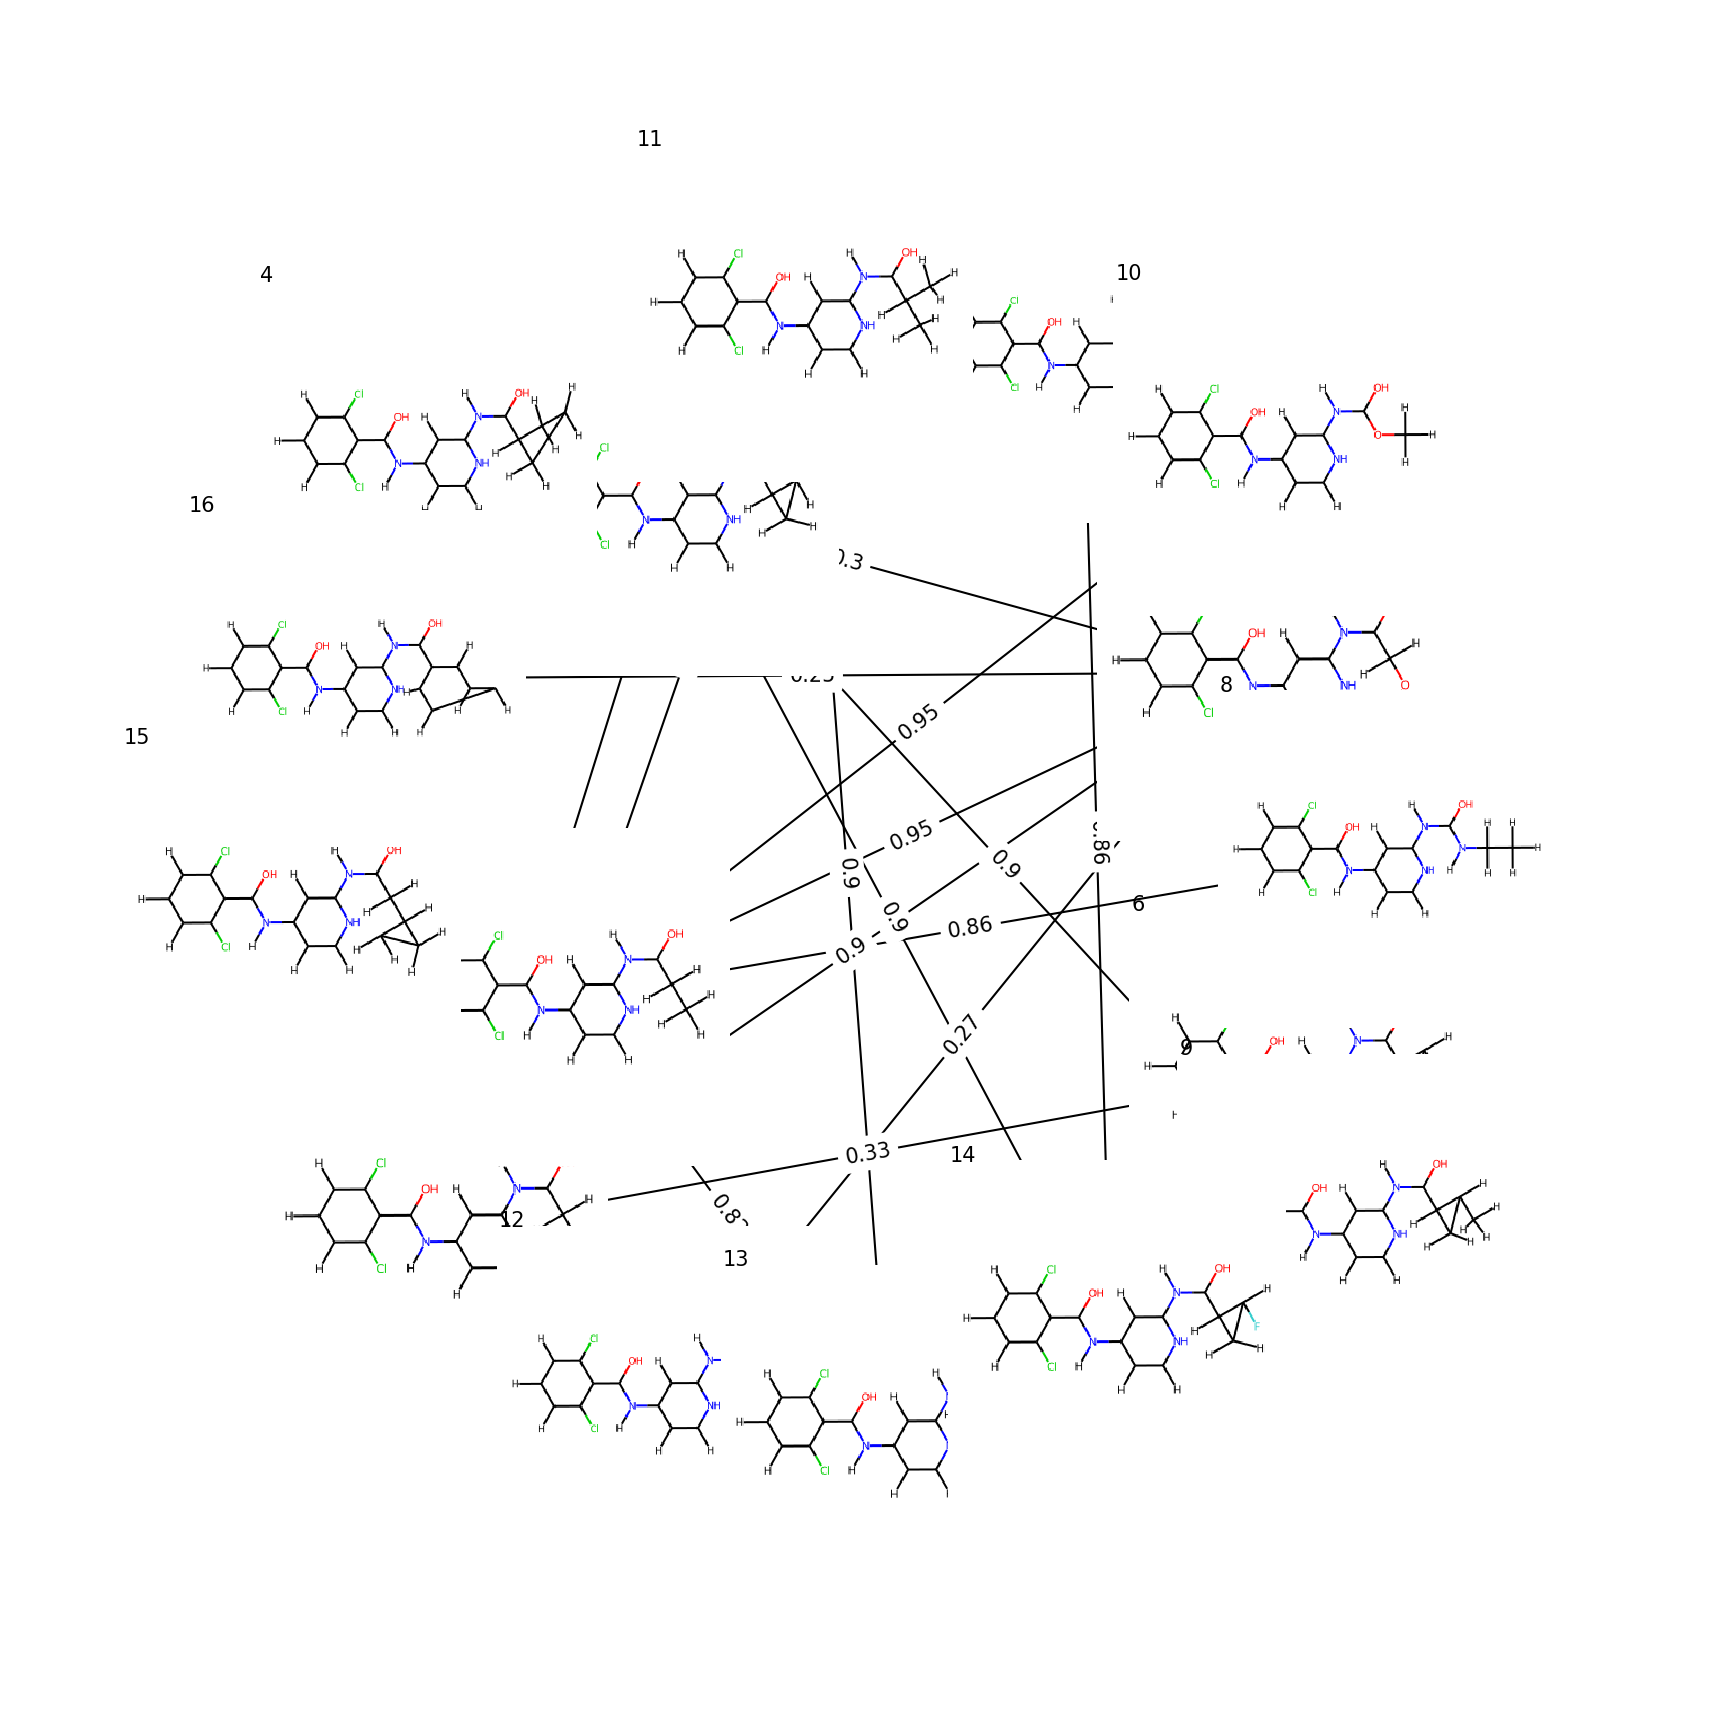

In [21]:
ligand_files = glob.glob("{}/*.mol2".format(path_to_ligands))

ligands = []
ligand_names = []

for filepath in ligand_files:
    # append the molecule object to a list.
    ligands.append(BSS.IO.readMolecules(filepath)[0])
    
    # append the molecule name to another list so that we can use the name of each molecule in our workflow.
    ligand_names.append(filepath.split("/")[-1].replace(".mol2",""))

tranformations, lomap_scores = BSS.Align.generateNetwork(ligands)

BioSimSpace uses NetworkX which works with node indices for node names. Let's adjust our list of edges to have ligand names instead of ligand indices:

In [8]:
transformations_named = [(ligand_names[transf[0]], ligand_names[transf[1]]) for transf in tranformations]
for transf, score in zip(transformations_named, lomap_scores):
    print(transf, score)

('ejm_31', 'ejm_50') 0.90484
('ejm_31', 'ejm_46') 0.36788
('ejm_31', 'ejm_47') 0.33287
('ejm_31', 'jmc_27') 0.33287
('ejm_31', 'ejm_42') 0.90484
('ejm_31', 'ejm_48') 0.30119
('ejm_31', 'ejm_45') 0.74082
('ejm_31', 'ejm_49') 0.27253
('ejm_50', 'ejm_47') 0.30119
('ejm_50', 'ejm_42') 0.95123
('ejm_50', 'ejm_48') 0.27253
('ejm_50', 'ejm_49') 0.2466
('ejm_46', 'jmc_28') 0.90484
('ejm_46', 'jmc_23') 0.90484
('jmc_30', 'jmc_28') 0.90484
('jmc_30', 'jmc_23') 0.86071
('jmc_27', 'jmc_28') 0.95123
('jmc_27', 'jmc_23') 0.95123
('ejm_42', 'ejm_54') 0.86071
('ejm_42', 'ejm_55') 0.95123
('ejm_42', 'ejm_43') 0.90484
('ejm_42', 'ejm_44') 0.81873
('ejm_54', 'ejm_55') 0.86071
('ejm_43', 'ejm_44') 0.90484


Unfortunately, even cutting-edge perturbation network generators such as LOMAP require some manual tweaking. In some cases, a ligand will have poor LOMAP scores on its edges and is therefore likely to be unreliable. To increase its reliability we often want to create an additional edge to this ligand, which can be easily done by appending the edge to our list of edges. 
NB: because we've already run LOMAP this edge will not have an associated LOMAP score.

In [9]:
transformations_named.append(('ejm_49', 'ejm_54'))
transformations_named

[('ejm_31', 'ejm_50'),
 ('ejm_31', 'ejm_46'),
 ('ejm_31', 'ejm_47'),
 ('ejm_31', 'jmc_27'),
 ('ejm_31', 'ejm_42'),
 ('ejm_31', 'ejm_48'),
 ('ejm_31', 'ejm_45'),
 ('ejm_31', 'ejm_49'),
 ('ejm_50', 'ejm_47'),
 ('ejm_50', 'ejm_42'),
 ('ejm_50', 'ejm_48'),
 ('ejm_50', 'ejm_49'),
 ('ejm_46', 'jmc_28'),
 ('ejm_46', 'jmc_23'),
 ('jmc_30', 'jmc_28'),
 ('jmc_30', 'jmc_23'),
 ('jmc_27', 'jmc_28'),
 ('jmc_27', 'jmc_23'),
 ('ejm_42', 'ejm_54'),
 ('ejm_42', 'ejm_55'),
 ('ejm_42', 'ejm_43'),
 ('ejm_42', 'ejm_44'),
 ('ejm_54', 'ejm_55'),
 ('ejm_43', 'ejm_44'),
 ('ejm_49', 'ejm_54')]

## 2. Write files for execution model
These data files are used when running a FEP pipeline using BSS. Copy the folder ./execution_model/ to a server to parallelise your simulations.

In [11]:
# write ligands file.
with open("./execution_model/ligands.dat", "w") as ligands_file:
    writer = csv.writer(ligands_file)
    for lig in ligand_names:
        writer.writerow([lig])

In [12]:
# write lambda windows per perturbation. Separating this cell and the next one allows the user to
# edit the windows file if >7 windows are required for some perturbations.
with open("./execution_model/lambdas_per_pert.dat", "w") as lambda_file:
    writer = csv.writer(lambda_file)
    writer.writerow(["lig1", "lig2", "n_lambda"])
    for pert in transformations_named:
        
        writer.writerow([pert[0], pert[1], 7])

Before running the next cell, user can change the lambda scheduling per perturbation in ./outputs/execution_model/lambdas_per_pert.dat

In [18]:
# write perts file. Base the lambda schedule on the file generated in the previous cell.
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

with open("./execution_model/network.dat", "w") as network_file, \
open("./execution_model/lambdas_per_pert.dat", "r") as lambda_file:
    writer = csv.writer(network_file, delimiter=" ")
    reader = csv.reader(lambda_file)
    
    # skip header.
    next(reader)
    
    for pert in reader:
        # given the number of allocated lambda windows, generate an array for parsing downstream.
        lam_array = str(np.around(np.linspace(0, 1, int(pert[2])), decimals=4))
        # make the array into a format readable by bash.
        lam_array = lam_array.replace("[ ", "").replace("]", "").replace("  ", ",")
        
        # write out both directions for this perturbation.
        writer.writerow([pert[0], pert[1], lam_array])
        writer.writerow([pert[1], pert[0], lam_array])

Finally, set a protocol to run our simulations with. This file instructs BioSimSpace on the cluster.

In [14]:
# create protocol. 
protocol = [
    "ligand forcefield = GAFF2/AM1-BCC",
    "protein forcefield = ff14SB",
    "solvent = TIP3P",
    "box edges = 10*angstrom",
    "box type = orthorhombic",
    "protocol = default ",
    "sampling = 2*ns",
    "engine = SOMD"
]

In [15]:
# write protocol to file.
with open("./execution_model/protocol.dat", "w") as protocol_file:
    writer = csv.writer(protocol_file)

    for prot_line in protocol:
        
        writer.writerow([prot_line])

Finally, parameterise our protein structure and save the system to the execution model folder.

In [ ]:
prot = BSS.IO.readPDB(path_to_protein+".pdb")

prot_p = BSS.Parameters.ff14SB(prot).getMolecule()   # this might take a few minutes.

In [36]:
BSS.IO.saveMolecules("execution_model/inputs/protein/protein", prot, fileformat=["PRM7", "RST7"])

OSError: Failed to save system to format: 'PRM7'